# Analyzing the effect of income and area of residence on quality of education

### Introduction
The Scholastic Aptitude Test (SAT) is a standardized test taken by most high school students across the United States (and some international students), often used for post-secondary admissions (Johnson, n.d.). The question we will try to answer with the project is: What SAT score is a NYC student likely to get as a result of their income and their school's student enrollment(the  the number of students that currently attend a school)? A dataset listing the average SAT scores per school in New York will be used; this dataset also lists the student enrollment of each school. The average SAT scores of all schools in varying levels of student enrollment will then be compared with data from an income per student enrollment database.

### Methods
We will use linear regression to predict SAT scores given household income. From the average SAT scores dataset, we will be using Average SAT Scores (math, reading, writing), and student enrollment. From the average income data, we will be using Zip.Code, total_pop, total_income, and avg_income. We will visualize the results with a scatterplot (average SAT scores per student enrollment vs. average income per student enrollment)

### Expectations
We expect that schools with less student enrollment will ahave higher SAT scores as private schools are more likely to have lower student enrollment and higher SAT scores (Frenette & Chan 2015). If data suggests so, actions could be taken to minimize the effect of student enrollment on one's education. An example of a future question this could lead to is: What are other environmental factors that may influence average SAT scores of students?

## Preliminary exploratory data analysis

### Run before

In [19]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
library(cowplot)

Warning message:
“package ‘cowplot’ was built under R version 4.0.3”


### Download files

In [2]:
sat_scores <- read_csv("https://raw.githubusercontent.com/emi31770/DSCI-Project/main/datasets/sat_scores.csv")
zip_income <- read_csv("https://raw.githubusercontent.com/emi31770/DSCI-Project/main/datasets/zipcodes_income.csv")
colnames(sat_scores) <- make.names(colnames(sat_scores))
colnames(zip_income) = make.names(colnames(zip_income))
write_csv(sat_scores, "sat.csv")
write_csv(zip_income, "zip.csv")

Parsed with column specification:
cols(
  .default = col_character(),
  `Zip Code` = col_double(),
  Latitude = col_double(),
  Longitude = col_double(),
  `Start Time` = col_time(format = ""),
  `End Time` = col_time(format = ""),
  `Student Enrollment` = col_double(),
  `Average Score (SAT Math)` = col_double(),
  `Average Score (SAT Reading)` = col_double(),
  `Average Score (SAT Writing)` = col_double()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  state = col_character(),
  zipcode = col_double(),
  total_pop = col_double(),
  total_income = col_double(),
  country = col_character(),
  avg_income = col_double()
)



In [3]:
zip_income <- read_csv("zip.csv")
sat_scores <- read_csv("sat.csv")

head(zip_income, 5)
head(sat_scores, 5)

Parsed with column specification:
cols(
  state = col_character(),
  zipcode = col_double(),
  total_pop = col_double(),
  total_income = col_double(),
  country = col_character(),
  avg_income = col_double()
)

Parsed with column specification:
cols(
  .default = col_character(),
  Zip.Code = col_double(),
  Latitude = col_double(),
  Longitude = col_double(),
  Start.Time = col_time(format = ""),
  End.Time = col_time(format = ""),
  Student.Enrollment = col_double(),
  Average.Score..SAT.Math. = col_double(),
  Average.Score..SAT.Reading. = col_double(),
  Average.Score..SAT.Writing. = col_double()
)

See spec(...) for full column specifications.



state,zipcode,total_pop,total_income,country,avg_income
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
AK,0,345220,25354974,USA,73445.84
AK,99501,7690,612242,USA,79615.34
AK,99502,11860,1000685,USA,84374.79
AK,99503,7510,462394,USA,61570.44
AK,99504,19440,1176109,USA,60499.43


School.ID,School.Name,Borough,Building.Code,Street.Address,City,State,Zip.Code,Latitude,Longitude,⋯,End.Time,Student.Enrollment,Percent.White,Percent.Black,Percent.Hispanic,Percent.Asian,Average.Score..SAT.Math.,Average.Score..SAT.Reading.,Average.Score..SAT.Writing.,Percent.Tested
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<time>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
02M260,Clinton School Writers and Artists,Manhattan,M933,425 West 33rd Street,Manhattan,NY,10001,40.75321,-73.99786,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
06M211,Inwood Early College for Health and Information Technologies,Manhattan,M052,650 Academy Street,Manhattan,NY,10002,40.86605,-73.92486,⋯,15:00:00,87,3.4%,21.8%,67.8%,4.6%,NA,NA,NA,NA
01M539,"New Explorations into Science, Technology and Math High School",Manhattan,M022,111 Columbia Street,Manhattan,NY,10002,40.71873,-73.97943,⋯,16:00:00,1735,28.6%,13.3%,18.0%,38.5%,657,601,601,91.0%
02M294,Essex Street Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,⋯,14:45:00,358,11.7%,38.5%,41.3%,5.9%,395,411,387,78.9%
02M308,Lower Manhattan Arts Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,⋯,15:00:00,383,3.1%,28.2%,56.9%,8.6%,418,428,415,65.1%


In [4]:
zip_income <- zip_income %>% 
                filter(state == "NY", country == "USA") %>% 
                mutate(Zip.Code = zipcode) %>% 
                select(Zip.Code, total_pop, total_income, avg_income)

sat_scores <- sat_scores %>% 
                mutate(total_score_avg = Average.Score..SAT.Math. + Average.Score..SAT.Reading. + Average.Score..SAT.Writing.) %>%
                select(Zip.Code, Student.Enrollment, total_score_avg, Average.Score..SAT.Math., Average.Score..SAT.Reading., Average.Score..SAT.Writing.) %>%
                na.omit() %>%
                group_by(Zip.Code) %>%
                summarize_all("mean")


joined_tables <- merge(x = sat_scores,y = zip_income, by = "Zip.Code")
joined_tables = joined_tables %>%
                        mutate(Zip.Code = as_factor(Zip.Code))


head(joined_tables, 5)

,Zip.Code,Student.Enrollment,total_score_avg,Average.Score..SAT.Math.,Average.Score..SAT.Reading.,Average.Score..SAT.Writing.,total_pop,total_income,avg_income
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10002,504.7273,1358.909,472.9091,448.5455,437.4545,42400,2718913,64125.31
2,10003,693.2000,1323.600,449.6000,443.4000,430.6000,29270,8191737,279868.02
3,10004,519.2500,1380.250,463.0000,462.0000,455.2500,2470,944925,382560.73
4,10006,747.5000,1268.000,429.5000,419.0000,419.5000,2510,577145,229938.25
5,10009,666.0000,1327.000,454.0000,428.0000,445.0000,33200,2948597,88813.16


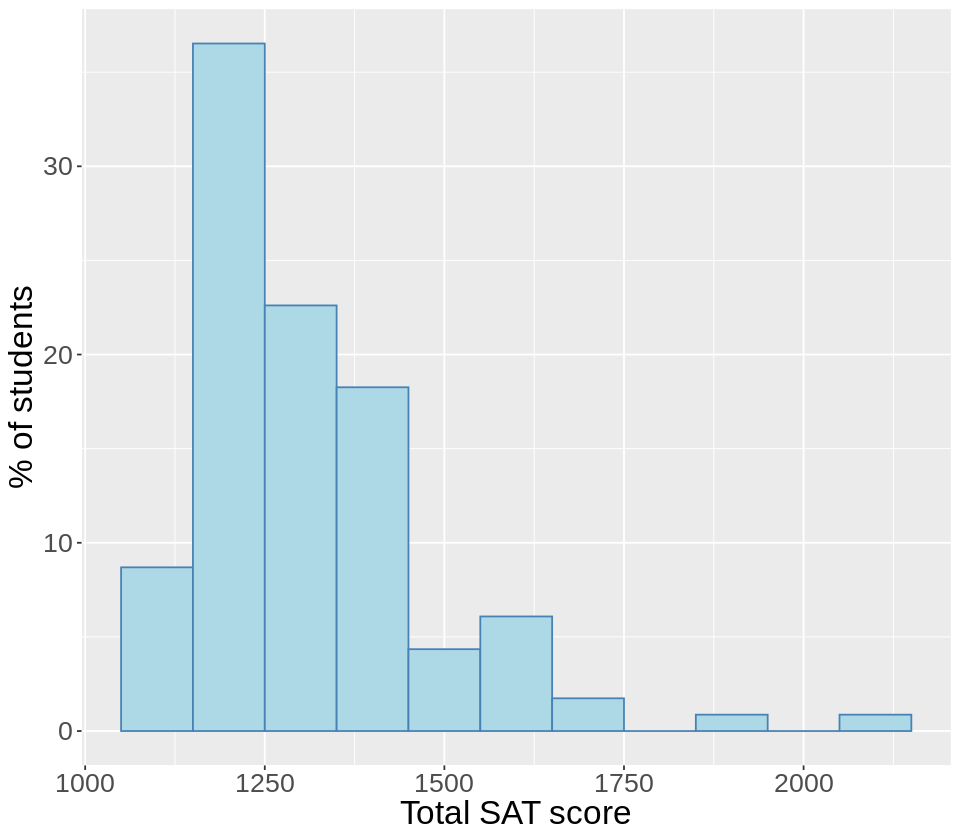

In [11]:
options(repr.plot.width = 8, repr.plot.height = 7)

SAT_dist_plot <- ggplot(joined_tables, aes(x = total_score_avg)) +
                   geom_histogram(aes(y = 100 * stat(count) / sum(stat(count))),
                   binwidth = 100,
                   fill = "lightblue",
                   color = "steelblue") +
                   ylab("% of students") +
                   xlab("Total SAT score") + 
                   theme(text = element_text(size = 20))

SAT_dist_plot 

In [12]:
set.seed(4321)

sat_split <- initial_split(joined_tables, prop = 0.75, strata = total_score_avg)
sat_training <- training(sat_split)
sat_testing <- testing(sat_split)

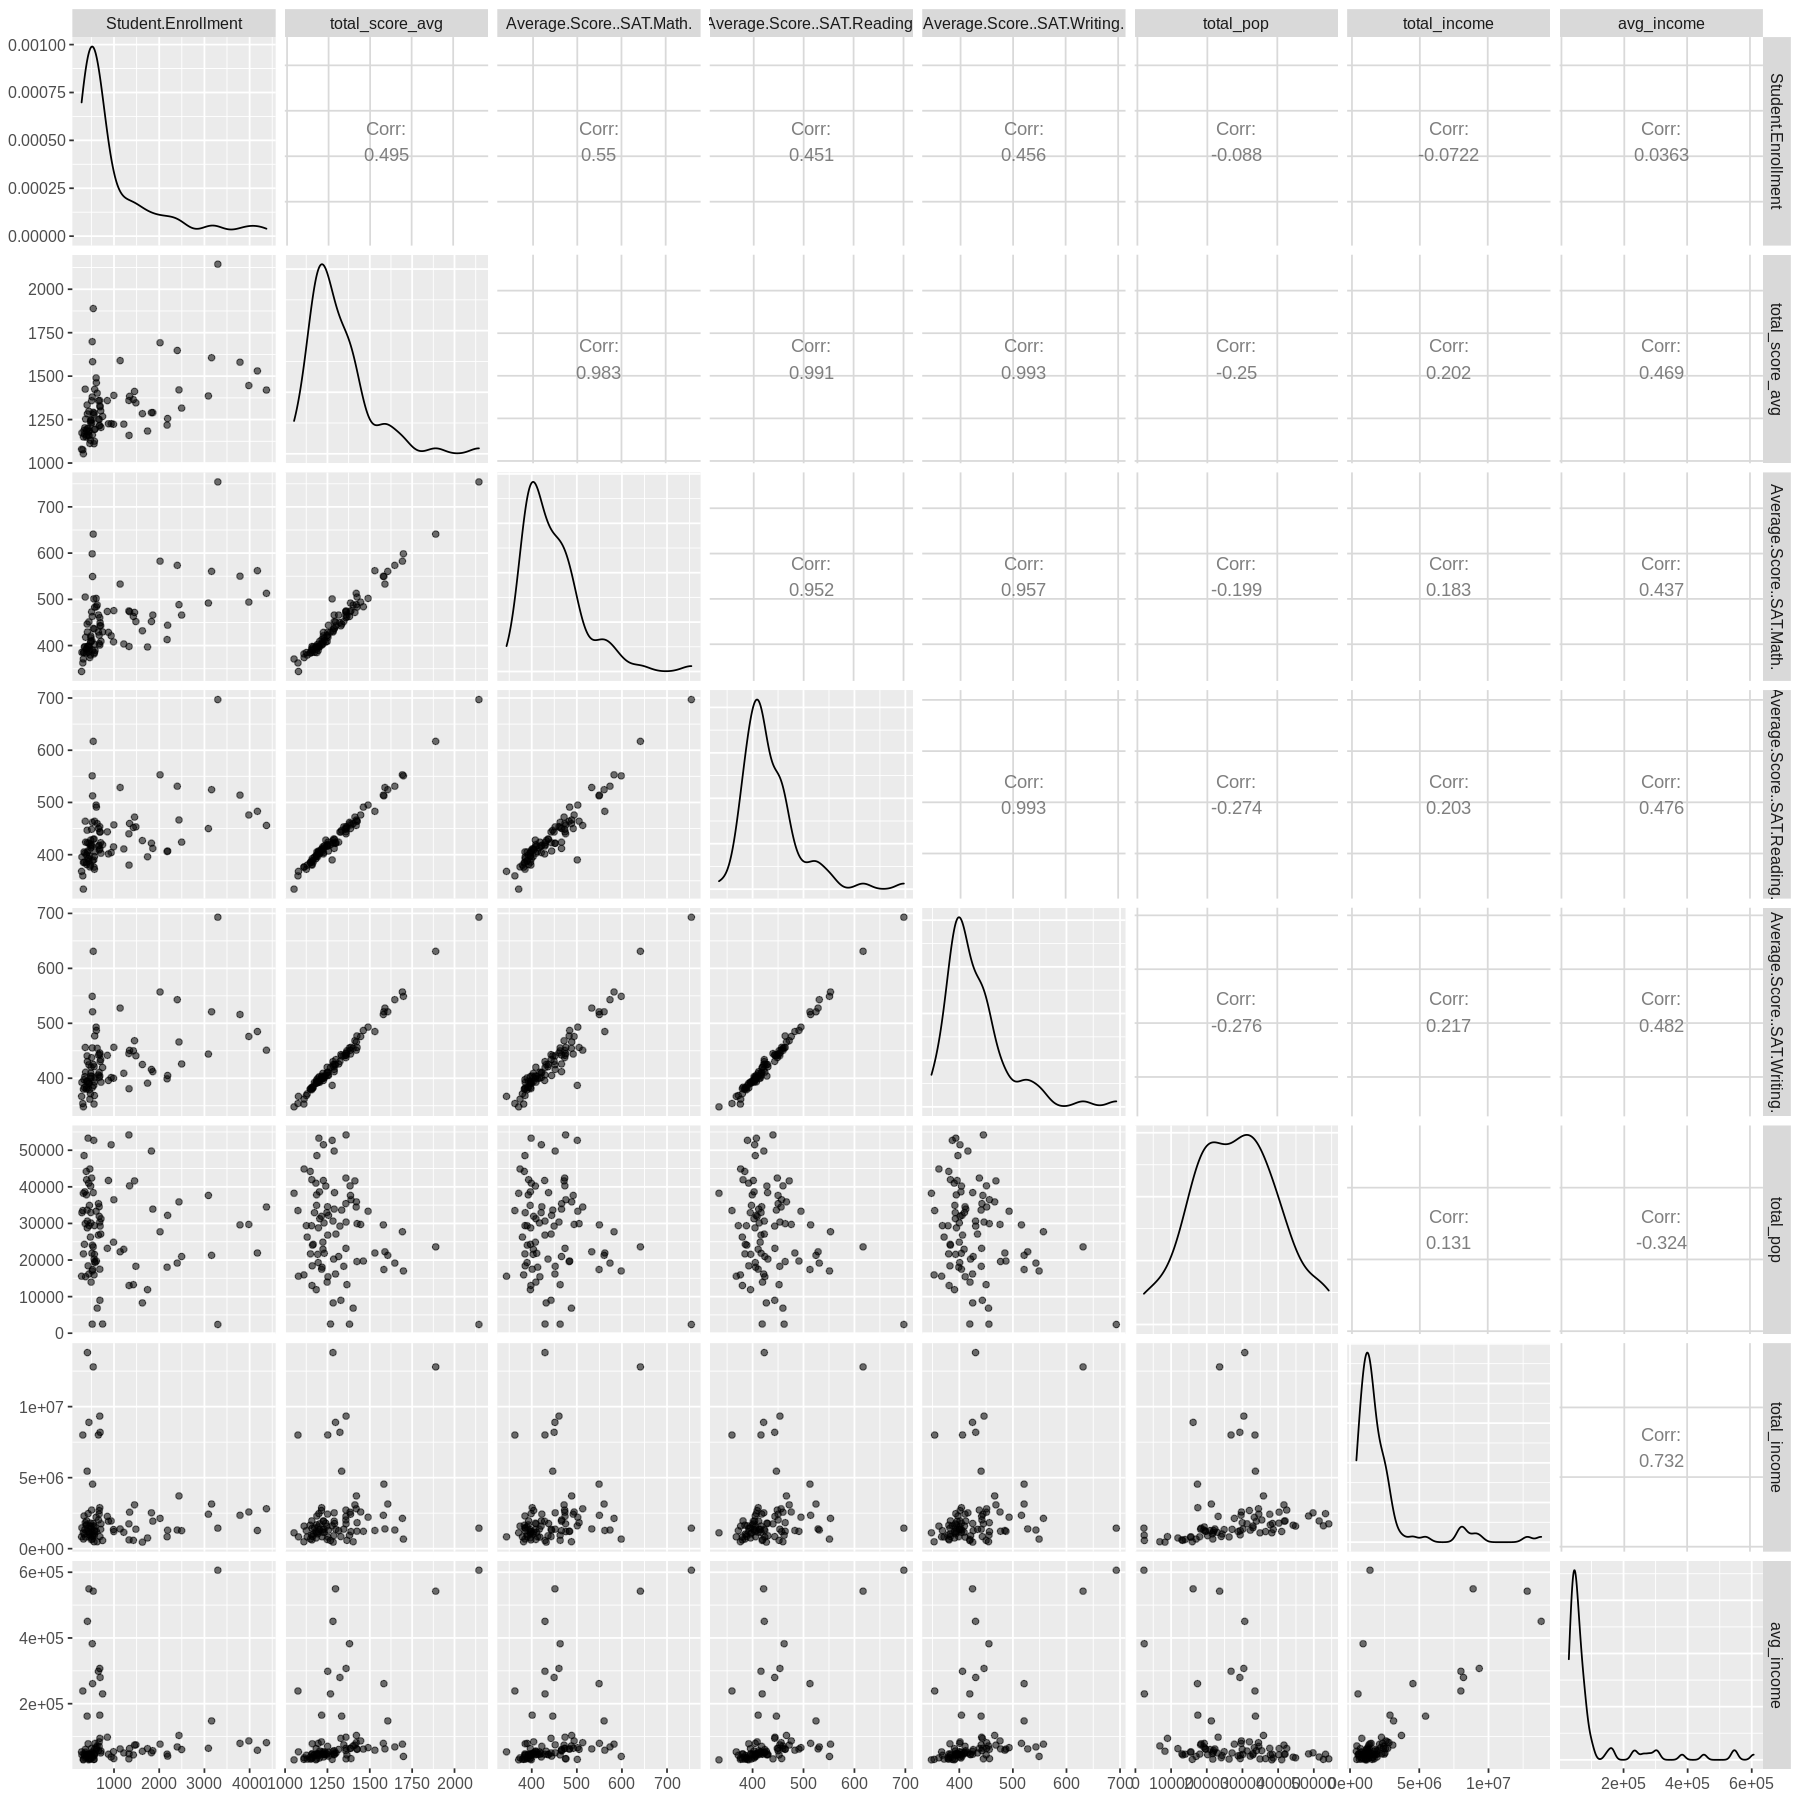

In [13]:
options(repr.plot.width = 15, repr.plot.height = 15)

sat_eda <- sat_training %>%
                select(-Zip.Code) %>%
                ggpairs(mapping = aes(alpha = 0.4)) +
                theme(text = element_text(size = 12))

sat_eda

since student enrollment has higher correlation, it'll be the predictor we choose to use. 

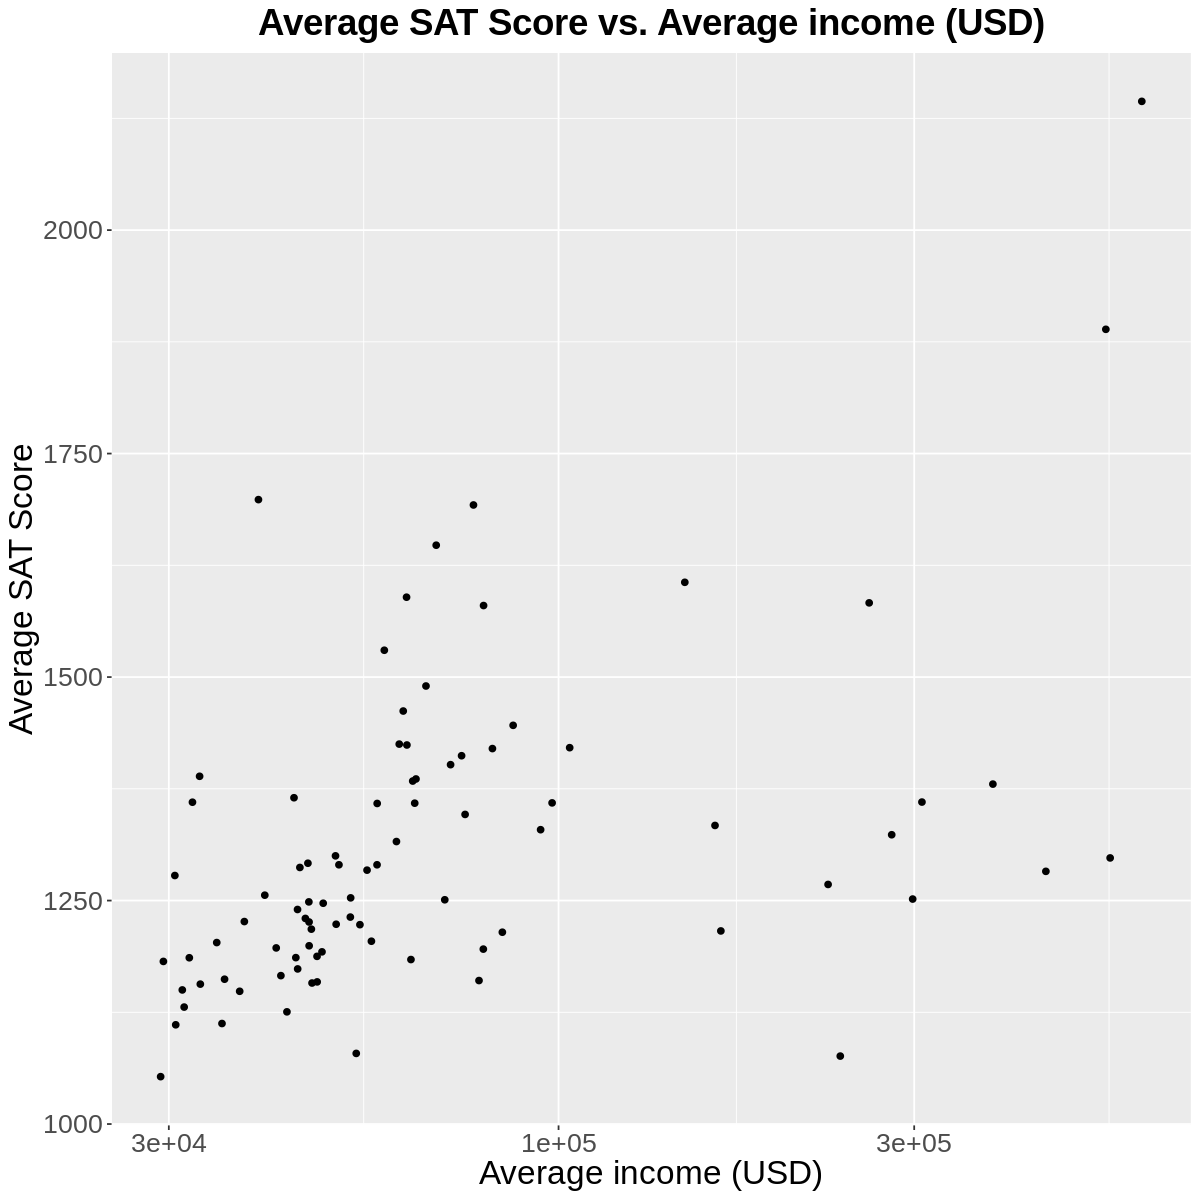

In [14]:
options(repr.plot.width = 10, repr.plot.height = 10)

scores_income <- ggplot(sat_training, aes(x = avg_income, y = total_score_avg)) +
                    geom_point() +
                    xlab("Average income (USD)") +
                    scale_x_log10() +
                    ylab("Average SAT Score") +
                    theme(text = element_text(size = 20)) +
                    ggtitle("Average SAT Score vs. Average income (USD)") +
                    theme(plot.title = element_text(size = 22)) +
                    theme(plot.title = element_text(face = "bold")) +
                    theme(plot.title = element_text(hjust = 0.5)) 

scores_income

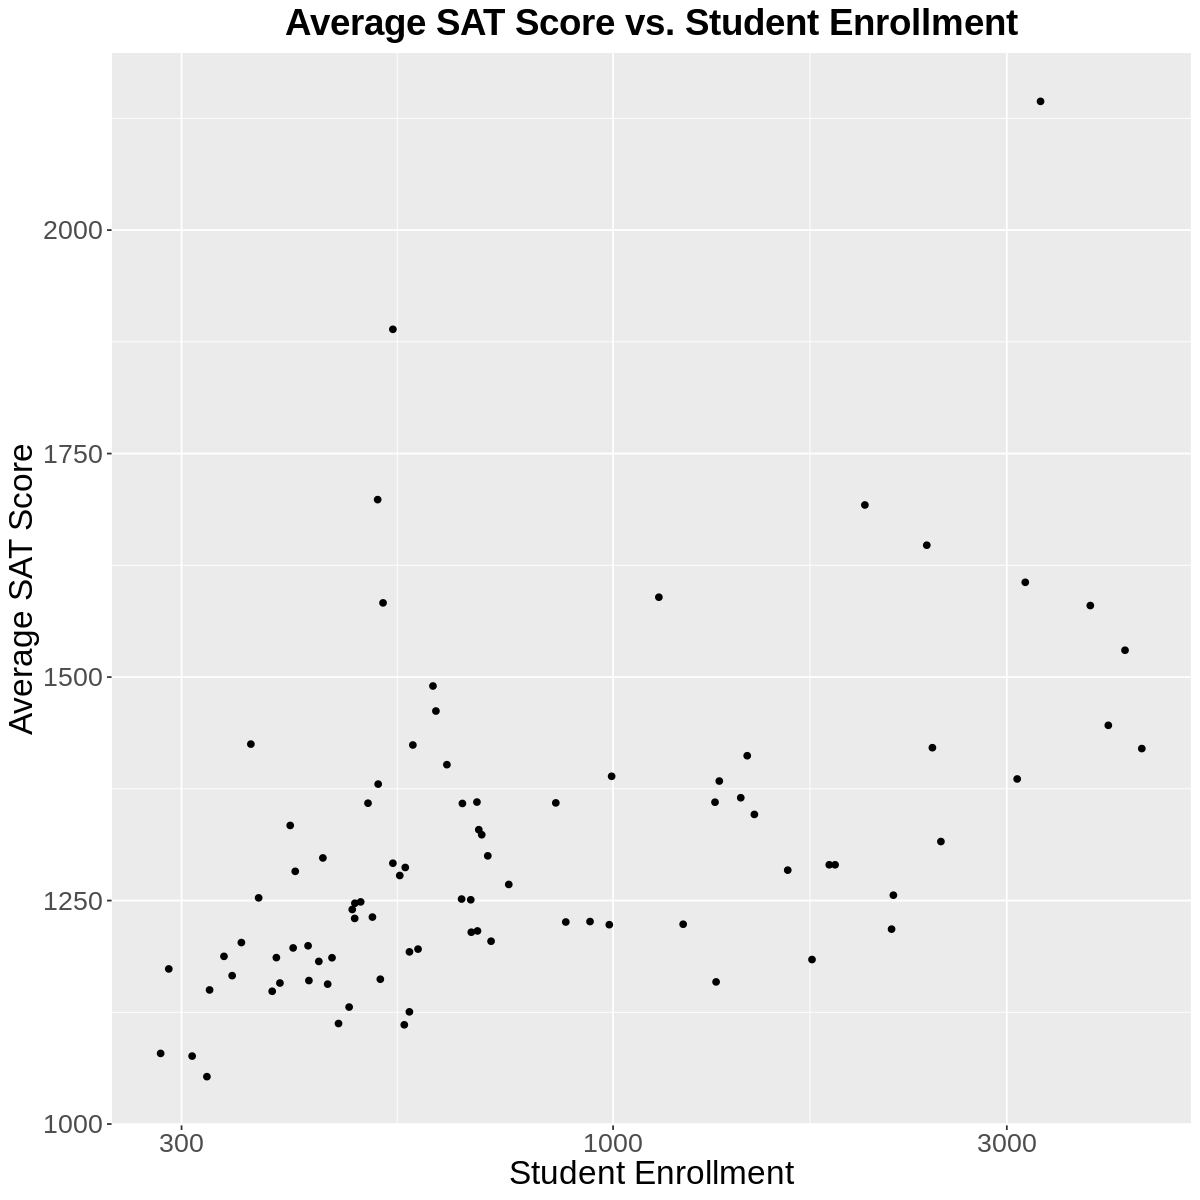

In [16]:
options(repr.plot.width = 10, repr.plot.height = 10)

scores_students <- ggplot(sat_training, aes(x = Student.Enrollment, y = total_score_avg)) +
                    geom_point() +
                    xlab("Student Enrollment") +
                    scale_x_log10() +
                    ylab("Average SAT Score") +
                    theme(text = element_text(size = 20)) +
                    ggtitle("Average SAT Score vs. Student Enrollment") +
                    theme(plot.title = element_text(size = 22)) +
                    theme(plot.title = element_text(face = "bold")) +
                    theme(plot.title = element_text(hjust = 0.5)) 

scores_students

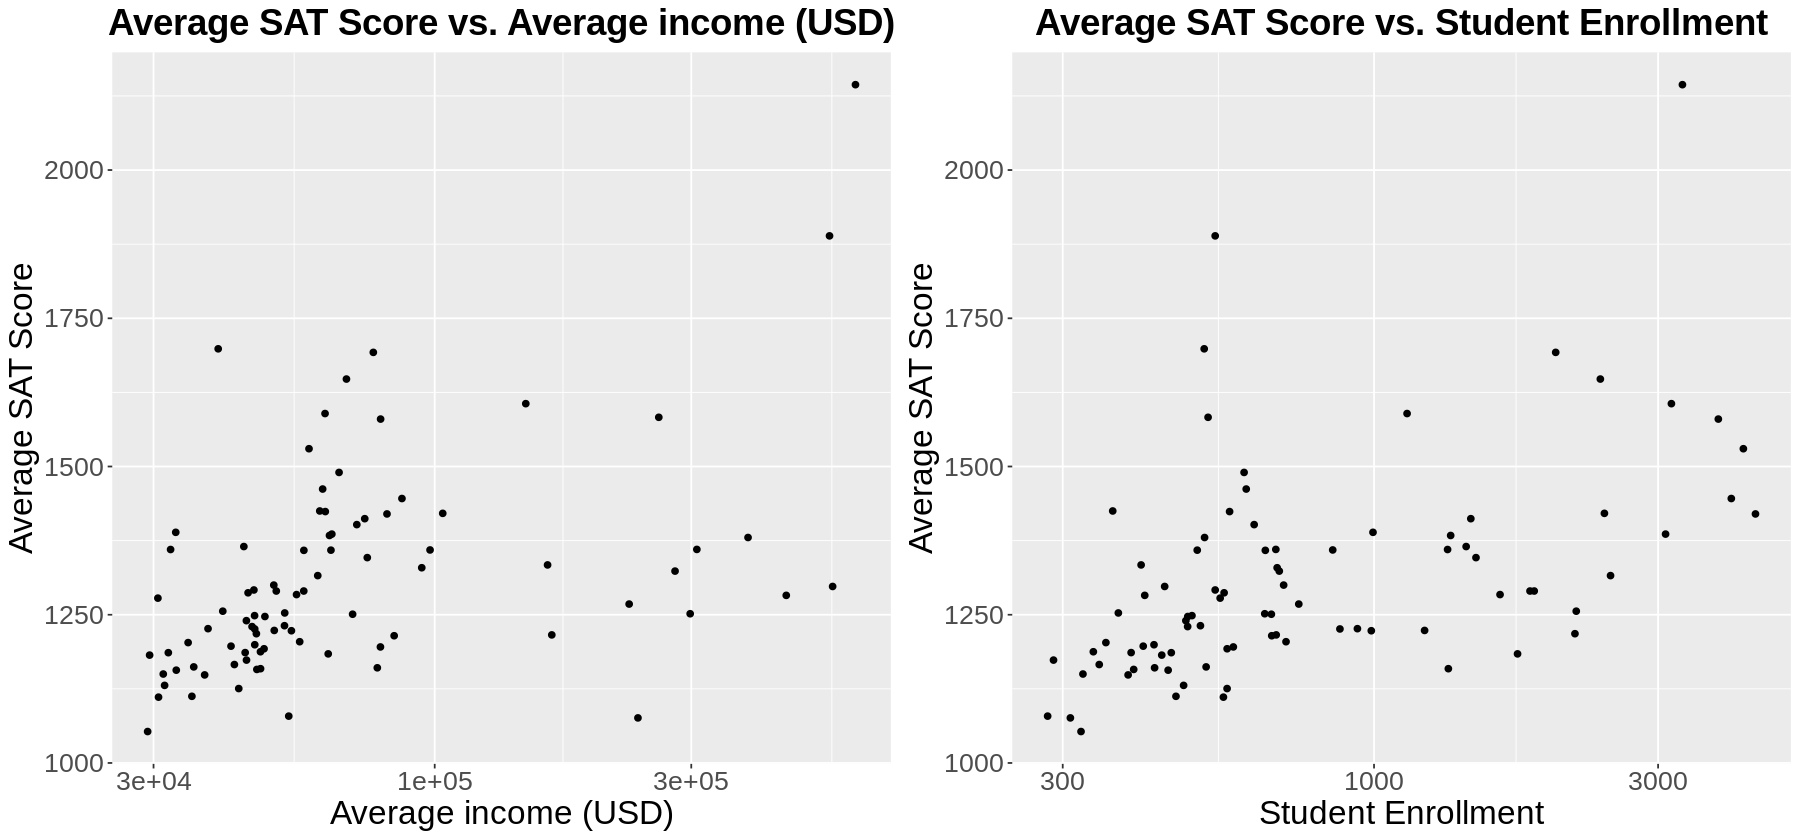

In [20]:
options(repr.plot.width = 15, repr.plot.height = 7)
plot_grid(scores_income, scores_students, ncol = 2)

In [9]:
set.seed(2021)

sat_vfold <- vfold_cv(sat_training, v = 5, strata = total_score_avg)

k_vals <- tibble(neighbors = seq(from = 1, to=20))

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                set_engine("kknn") %>%
                set_mode("regression")

sat_recipe <- recipe(total_score_avg ~ Student.Enrollment + avg_income, data = sat_training) %>%
                step_scale(all_predictors()) %>% 
                step_center(all_predictors())

sat_workflow <- workflow() %>%
                add_recipe(sat_recipe) %>%
                add_model(knn_spec)

sat_results <- sat_workflow %>%
                tune_grid(resamples = sat_vfold, grid = k_vals) %>%
                collect_metrics() %>%
                filter(.metric == "rmse")

sat_results

k_min <- sat_results %>% 
            filter(mean == min(mean)) %>% 
            pull(neighbors)

k_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,191.7310,5,19.95759,Model01
2,rmse,standard,167.7382,5,14.17906,Model02
3,rmse,standard,168.6480,5,15.45918,Model03
4,rmse,standard,167.6123,5,16.68545,Model04
5,rmse,standard,163.9438,5,17.87449,Model05
6,rmse,standard,162.9491,5,17.49002,Model06
7,rmse,standard,157.1380,5,17.88009,Model07
8,rmse,standard,151.4284,5,17.60878,Model08
9,rmse,standard,152.0155,5,17.65508,Model09


[1] 8

In [10]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
                set_engine("kknn") %>%
                set_mode("regression")

sat_workflow <- workflow() %>%
                add_recipe(sat_recipe) %>%
                add_model(knn_spec)

sat_fit <- sat_workflow %>%
            fit(data = sat_training)

sat_rmspe <- sat_fit %>%
            predict(sat_testing) %>%
            bind_cols(sat_testing) %>%
            metrics(truth = total_score_avg, estimate = .pred) %>%
            filter(.metric == 'rmse') %>%
            select(.estimate) %>%
            pull()

sat_rmspe

[1] 87.42148

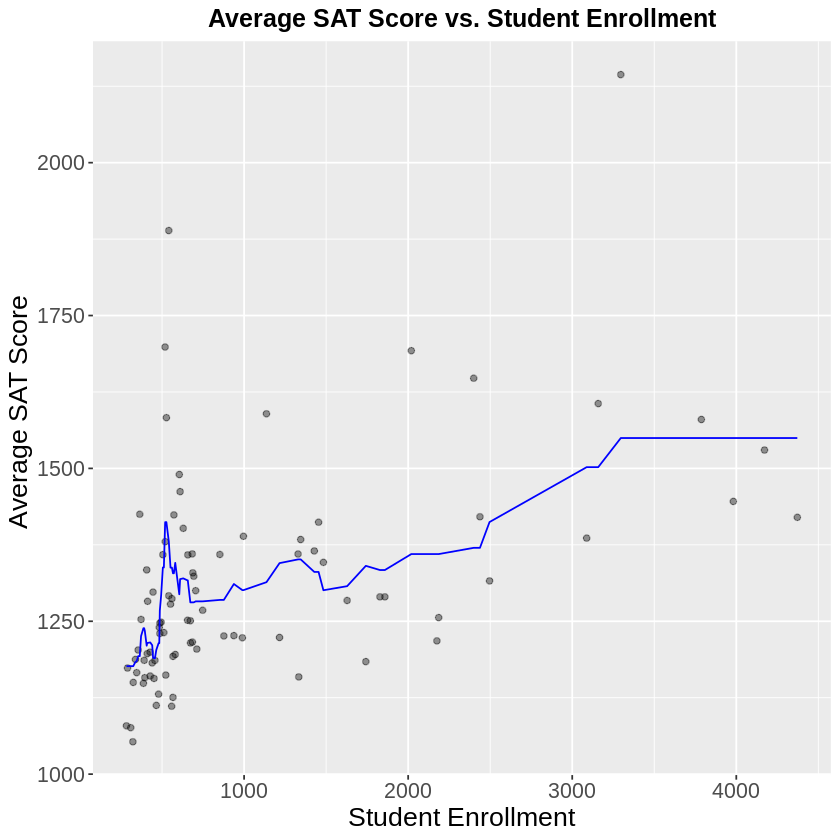

In [30]:
options(repr.plot.width = 7, repr.plot.height = 7)

sat_preds <- sat_fit %>%
                    predict(sat_training) %>%
                    bind_cols(sat_training)

sat_plot <- ggplot(sat_preds, aes(x = Student.Enrollment, y = total_score_avg)) + 
                geom_point(alpha = 0.4) +
                geom_line(data = sat_preds, aes(x = Student.Enrollment, y = .pred), color = 'blue') +
                ggtitle("Average SAT Score vs. Student Enrollment") +
                theme(plot.title = element_text(size = 15)) +
                theme(plot.title = element_text(face = "bold")) +
                theme(plot.title = element_text(hjust = 0.5)) +
                labs(x = "Student Enrollment", y = "Average SAT Score ") +
                theme(text = element_text(size = 16))

sat_plot

### References

Frenette, M., & Chan, P. (2015, November 27). Academic Outcomes of Public and Private High School Students: What Lies Behind the Differences? Retrieved April 8, 2022 from https://www150.statcan.gc.ca/n1/pub/11f0019m/11f0019m2015367-eng.htm.

Gunasekara, H. (2021). Average Income per Zip Code USA 2018. Retrieved April 8, 2022 from https://www.kaggle.com/datasets/hamishgunasekara/average-income-per-zip-code-usa-2018.

Johnson, T. (n.d.). SAT. Retrieved April 8, 2022 from https://tea.texas.gov/academics/college-career-and-military-prep/sat.

NYC Open Data. (2017). Average SAT Scores for NYC Public Schools. Retrieved April 8, 2022 from https://www.kaggle.com/datasets/nycopendata/high-schools.